In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #绘图模块，基于matplotlib的可视化python包,不能完全替代matplotlib,只是对matplotlib进行升级
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline

#pip install seaborn

## 1.加载数据

In [89]:
#parse_dates:将指定的列加载成日期的格式
offline = pd.read_csv('ccf_offline_stage1_train.csv',parse_dates=['Date_received','Date'])
offline.info()  #175+万条数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   User_id        int64         
 1   Merchant_id    int64         
 2   Coupon_id      float64       
 3   Discount_rate  object        
 4   Distance       float64       
 5   Date_received  datetime64[ns]
 6   Date           datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 93.7+ MB


In [90]:
offline.head(10)   #NaT:时间日期格式的空值

User_id  Merchant_id  Coupon_id Discount_rate  Distance Date_received  \
0  1439408         2632        NaN           NaN       0.0           NaT   
1  1439408         4663    11002.0        150:20       1.0    2016-05-28   
2  1439408         2632     8591.0          20:1       0.0    2016-02-17   
3  1439408         2632     1078.0          20:1       0.0    2016-03-19   
4  1439408         2632     8591.0          20:1       0.0    2016-06-13   
5  1439408         2632        NaN           NaN       0.0           NaT   
6  1439408         2632     8591.0          20:1       0.0    2016-05-16   
7  1832624         3381     7610.0        200:20       0.0    2016-04-29   
8  2029232         3381    11951.0        200:20       1.0    2016-01-29   
9  2029232          450     1532.0          30:5       0.0    2016-05-30   

        Date  
0 2016-02-17  
1        NaT  
2        NaT  
3        NaT  
4        NaT  
5 2016-05-16  
6 2016-06-13  
7        NaT  
8        NaT  
9        NaT

## 2.数据的规整

In [91]:
#判断每一列当中有多少个空值
offline.isnull().sum()
#优惠券id，折扣率，领券日期，三者可能存在同时==null的情况

User_id               0
Merchant_id           0
Coupon_id        701602
Discount_rate    701602
Distance         106003
Date_received    701602
Date             977900
dtype: int64

### 2.1把“Discount_rate”列中的满减政策转换成折扣率

In [92]:
offline['Discount_rate'] = offline['Discount_rate'].fillna('null')
offline.head()

User_id  Merchant_id  Coupon_id Discount_rate  Distance Date_received  \
0  1439408         2632        NaN          null       0.0           NaT   
1  1439408         4663    11002.0        150:20       1.0    2016-05-28   
2  1439408         2632     8591.0          20:1       0.0    2016-02-17   
3  1439408         2632     1078.0          20:1       0.0    2016-03-19   
4  1439408         2632     8591.0          20:1       0.0    2016-06-13   

        Date  
0 2016-02-17  
1        NaT  
2        NaT  
3        NaT  
4        NaT

In [93]:
def discount_rate_opt(s): #s代表每一个元素
    if ':' in s:
        split = s.split(':')
        discount_rate = (int(split[0]) - int(split[1]))/int(split[0])
        return round(discount_rate,2)  #折扣率保留两位小数
    elif s == 'null':
        return np.NaN
    else:
        return float(s)

In [94]:
offline['Discount_rate']  = offline['Discount_rate'].map(discount_rate_opt)
offline.head()

User_id  Merchant_id  Coupon_id  Discount_rate  Distance Date_received  \
0  1439408         2632        NaN            NaN       0.0           NaT   
1  1439408         4663    11002.0           0.87       1.0    2016-05-28   
2  1439408         2632     8591.0           0.95       0.0    2016-02-17   
3  1439408         2632     1078.0           0.95       0.0    2016-03-19   
4  1439408         2632     8591.0           0.95       0.0    2016-06-13   

        Date  
0 2016-02-17  
1        NaT  
2        NaT  
3        NaT  
4        NaT

### 2.2 Coupon_id字段：null代表无优惠券，此时Discount_rate与Date_received字段无意义。
检查Coupon_id和Discount_rate与Date_received判断空值和非空值是否一一对应。

In [95]:
#np.all():判断一个课迭代数据中是否都为True，如果是返回True，否则返回False
np.all([True,False,True])

False

In [96]:
nan1 = offline['Coupon_id'].isnull()  #判断优惠券是否为空
nan2 = offline['Date_received'].isnull()   #判断领券日期是否为空
np.all(nan1 == nan2)  #如果结果=true，说明之前的猜测：Coupon_id与Date_received空值与非空值是一一对应的关系

True

In [97]:
nan3 = offline['Discount_rate'].isnull()
np.all(nan1 == nan3)#如果结果=true，说明之前的猜测：Coupon_id与Discount_rate空值与非空值是一一对应的关系

True

### 2.3
如果Date=null & Coupon_id!=null,有券未消费（cpon_no_consume）
如果Date=null & Coupon_id =null,无券未消费（no_cpon_no_consume）
如果Date！=null & Coupon_id=null,无券消费（no_cpon_consume）
如果Date！=null & Coupon_id!=null,有券消费（cpon_consume）

In [98]:
cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].notnull())]
no_cpon_no_consume = offline[(offline['Date'].isnull() & offline['Coupon_id'].isnull())]
no_cpon_consume = offline[(offline['Date'].notnull() & offline['Coupon_id'].isnull())]
cpon_consume = offline[(offline['Date'].notnull() & offline['Coupon_id'].notnull())]

In [99]:
print('有券未消费:{}'.format(len(cpon_no_consume)))
print('无券未消费:{}'.format(len(no_cpon_no_consume)))  #无意义，不需分析
print('无券消费:{}'.format(len(no_cpon_consume)))
print('有券消费:{}'.format(len(cpon_consume)))
#用优惠券消费的用7万，相比其他用户来说，占比较少

有券未消费:977900
无券未消费:0
无券消费:701602
有券消费:75382


## 3.数据分析


In [100]:
#绘制饼图占比
consume_status_dict = {'cpon_no_consume':len(cpon_no_consume),'no_cpon_consume':len(no_cpon_consume),'cpon_consume':len(cpon_consume)}
consume_status = pd.Series(consume_status_dict)
consume_status

cpon_no_consume    977900
no_cpon_consume    701602
cpon_consume        75382
dtype: int64

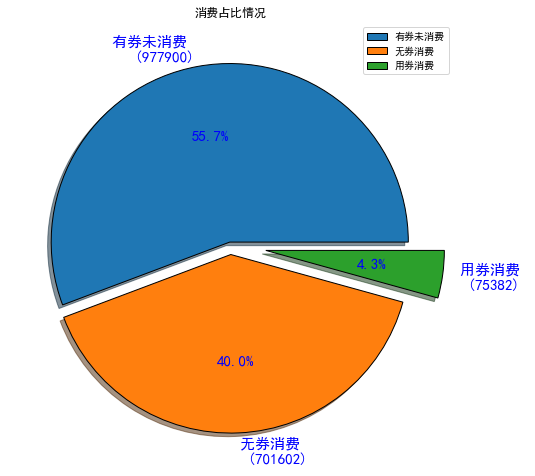

In [101]:
#消费方式构成的饼图（figure：看作是一张画布，axes：代表画布内的多个坐标系）
fig,ax=plt.subplots(1,1,figsize=(8,10))
consume_status.plot.pie(ax = ax,
                       autopct='%1.1f%%',
                       shadow=True,
                        explode=[0.02,0.05,0.2],
                        textprops={'fontsize':15,'color':'blue'},
                        wedgeprops={'linewidth':1,'edgecolor':'black'},
                        labels=['有券未消费 \n ({})'.format(len(cpon_no_consume)),
                                '无券消费 \n ({})'.format(len(no_cpon_consume)),
                               '用券消费 \n ({})'.format(len(cpon_consume))
                               ]
                       )
ax.set_ylabel('')  #去除ylable
ax.set_title('消费占比情况')
plt.legend(labels=['有券未消费','无券消费','用券消费'])
#有券未消费占比55.7%最大，说明大多数人拿完券之后，尚未使用
#无圈消费用户占比40%，说明很多人没有使用优惠券，可能优惠券的吸引力不大，客户没在意；可能，新用户比较多。
#用券消费用户占比较小4.3%,说明我们的优惠券使用率不高。可以考虑是不是加大优惠券力度.....

## 3.1在有券消费人群中，分析距离和优惠折扣

In [102]:
#各商家对应的顾客到店平均距离
Merchant_distance = cpon_consume.groupby('Merchant_id')['Distance'].mean()
Merchant_distance[Merchant_distance==0]
#有4076个商家，有1431个商家的用券消费用户平均范围在500米以内

Merchant_id
3       0.0
4       0.0
13      0.0
14      0.0
18      0.0
       ... 
8806    0.0
8824    0.0
8828    0.0
8849    0.0
8856    0.0
Name: Distance, Length: 1431, dtype: float64

Merchant_id
3       0.670
4       0.830
5       0.750
13      0.900
14      0.830
        ...  
8844    0.895
8849    0.950
8850    0.950
8852    0.950
8856    0.925
Name: Discount_rate, Length: 4076, dtype: float64

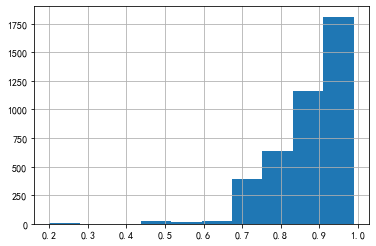

In [106]:
#各商家对应的顾客到店消费平均折扣力度
Merchant_discount_rate = cpon_consume.groupby('Merchant_id')['Discount_rate'].mean()
Merchant_discount_rate.sort_values()
Merchant_discount_rate.hist()
Merchant_discount_rate.mean()  #所有商家平均折扣的平均值：0.88
Merchant_discount_rate

## 3.2持券到店消费人数最多的商家

In [108]:
#对商家进行分组，取出用户id，对用户id进行去重统计数量、
popular_merchant = cpon_consume.groupby('Merchant_id')['User_id'].apply(lambda x:len(x.unique())).sort_values(ascending=False)
#找出持券消费人数>500的商家id
popular_merchant500 = popular_merchant[popular_merchant>500]
popular_merchant500.name = 'customer_count'  #指定列名为消费者数量（持券消费者）
print(len(popular_merchant500))
print(popular_merchant500)
#共有16家店铺，持券消费人数在500人以上
#持券消费人数最多商家是5341，持券消费人数在2800
#排名最后的商家，持券消费人数未559人
#这批商家对优惠券的使用方法得当，消费者喜欢用优惠券进行消费，可以适当借鉴这批商家的推广力度

16
Merchant_id
5341    2800
760     2627
3381    2248
6485    2029
2099    1401
2934    1310
450     1094
3532     968
7555     925
1520     870
6901     855
3621     851
4142     832
1379     587
1469     584
1433     559
Name: customer_count, dtype: int64


## 3.3持券消费人数在500人以上的商家，连接顾客到店平均距离和平均折扣力度

In [109]:
merchant_pop_dis = pd.merge(left=popular_merchant500,right=Merchant_distance,on='Merchant_id',how='inner')
merchant_pop_dis_rate = pd.merge(left=merchant_pop_dis,right=Merchant_discount_rate,on='Merchant_id',how='inner')
merchant_pop_dis_rate

customer_count  Distance  Discount_rate
Merchant_id                                         
5341                   2800  0.168598       0.826036
760                    2627  0.349866       0.799873
3381                   2248  1.652429       0.744150
6485                   2029  0.368567       0.770439
2099                   1401  0.968072       0.900000
2934                   1310  1.114833       0.830000
450                    1094  0.892164       0.819274
3532                    968  0.272498       0.852289
7555                    925  1.329977       0.828381
1520                    870       NaN       0.925632
6901                    855  0.557895       0.834165
3621                    851  0.472799       0.747565
4142                    832  0.555882       0.900000
1379                    587  0.706250       0.830096
1469                    584  2.092800       0.721870
1433                    559  1.054962       0.825959